In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, f1_score, precision_score, recall_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

from source import read_preprocessed_data
from transform import load_process_and_store_spreadsheets
from pipelines import benchmark_pipelines, build_classifier_pipelines, build_regression_pipelines, pipeline_Richard, pipeline_Julian
from pipelines import categorical_input_columns

RANDOM_STATE = 1234

In [3]:
def harmonic_mean(t0, t1):
    return t0 * t1 / (t0 + t1)

In [4]:
load_process_and_store_spreadsheets(transformation=harmonic_mean)

X_train, y_train = read_preprocessed_data("output/train.tsv")
X_test, y_test = read_preprocessed_data("output/test.tsv")

## Classification

In [5]:
y_train_resp = y_train["response_grouped"]
y_test_resp = y_test["response_grouped"]

In [6]:
ps_class = build_classifier_pipelines()

We want to predict non-responders:

In [7]:
response_labels = ['non responder (sd+pd)', 'responder (pr+cr)']
# pos_label = 'non responder (sd+pd)'
pos_label = 'responder (pr+cr)'

In [8]:
F1 = lambda x, y: f1_score(x, y, labels=response_labels, pos_label=pos_label)

In [9]:
from catboost import CatBoostClassifier
params = {
    'iterations': 400,
    'random_seed': RANDOM_STATE,
    'custom_loss': ['Precision', 'AUC', 'Accuracy', 'F1', 'Recall'],
    'eval_metric': 'F1',
    'logging_level': 'Silent',
}
cat = CatBoostClassifier(**params)

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
categorical_feature_indices = [X_train.columns.get_loc(column) for column in categorical_input_columns]

In [12]:
# cat.fit(
#     X_train, y_train_resp,
#     cat_features=categorical_feature_indices,
#     plot=True,
#     eval_set=(X_test, y_test_resp),
# )

## Architecure pipeline

In [13]:
# Calculate F_1 scores for the classifiers.
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=F1,
)
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.285714,0.620690,0.125000,0.444444
RandomForestClassifier,0.000000,0.533333,0.222222,0.000000
GaussianNB,0.095238,0.428571,0.411765,0.100000
GradientBoostingClassifier,0.000000,0.000000,0.000000,0.000000
KNeighborsClassifier,0.142857,0.315789,0.352941,0.153846
LogisticRegression,0.421053,0.382979,0.526316,0.421053
SVC,0.000000,0.000000,0.000000,0.000000
DummyClassifier,0.000000,0.000000,0.000000,0.000000


In [14]:
from sklearn.preprocessing import LabelBinarizer
def auc(y_true, y_pred):
    l = LabelBinarizer().fit(y_true)
    return roc_auc_score(l.transform(y_true), l.transform(y_pred), average='weighted')

In [15]:
b = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=auc,
)
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.463602,0.810345,0.452107,0.636015
RandomForestClassifier,0.396552,0.720307,0.490421,0.448276
GaussianNB,0.365900,0.586207,0.578544,0.383142
GradientBoostingClassifier,0.448276,0.500000,0.500000,0.500000
KNeighborsClassifier,0.486590,0.545977,0.580460,0.503831
LogisticRegression,0.618774,0.500000,0.691571,0.618774
SVC,0.500000,0.500000,0.500000,0.500000
DummyClassifier,0.500000,0.500000,0.500000,0.500000


In [16]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    0.472462
Julian_test     0.582854
Freeman_test    0.536638
Lev_test        0.511255
dtype: float64
--------------------
DecisionTreeClassifier        0.590517
RandomForestClassifier        0.513889
GaussianNB                    0.478448
GradientBoostingClassifier    0.487069
KNeighborsClassifier          0.529215
LogisticRegression            0.607280
SVC                           0.500000
DummyClassifier               0.500000
dtype: float64


In [17]:
from pipelines import hybrid_classifier
p = hybrid_classifier()
X_train, y_train_resp, X_test, y_test_resp
p.fit(X_train, y_train_resp)
y_train_pred = p.predict(X_train)
y_test_pred = p.predict(X_test)
auc(y_test_resp, y_test_pred)

0.6877394636015326

In [18]:
p_win = ps_class['DecisionTreeClassifier']['Julian']

The confusion matrix $M_{ij}$: predicted $i$ but truth is $j$.

Confusion matrix, without normalization
[[18 11]
 [ 0  9]]


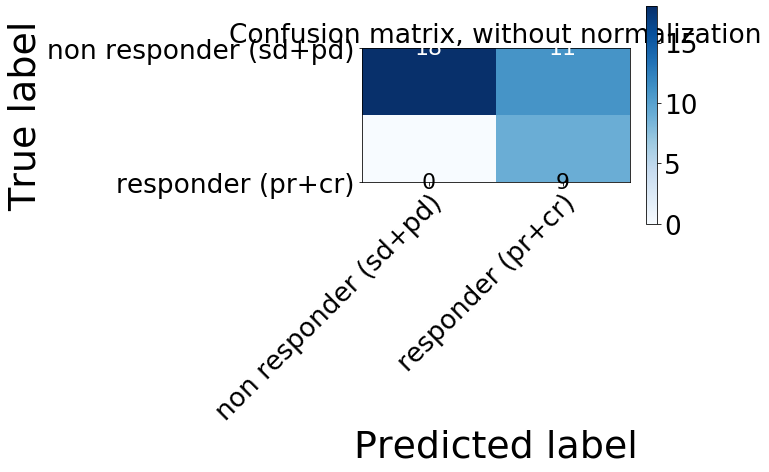

In [19]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, p_win.predict(X_test), classes=response_labels)

Precision:
$$p = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}$$

Recall or sensitivity:
$$r = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$$

In [20]:
r = lambda x,y: recall_score(x, y, labels=response_labels, pos_label=pos_label)
p = lambda x, y: precision_score(x, y, labels=response_labels, pos_label=pos_label)
recall = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=r,
)
recall

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.444444,1.000000,0.111111,0.444444
RandomForestClassifier,0.000000,0.888889,0.222222,0.000000
GaussianNB,0.111111,1.000000,0.777778,0.111111
GradientBoostingClassifier,0.000000,0.000000,0.000000,0.000000
KNeighborsClassifier,0.111111,0.333333,0.333333,0.111111
LogisticRegression,0.444444,1.000000,0.555556,0.444444
SVC,0.000000,0.000000,0.000000,0.000000
DummyClassifier,0.000000,0.000000,0.000000,0.000000


In [21]:
precision = benchmark_pipelines(
    ps_class, X_train, y_train_resp, X_test, y_test_resp, metric=p,
)
precision

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeClassifier,0.210526,0.450000,0.142857,0.444444
RandomForestClassifier,0.000000,0.380952,0.222222,0.000000
GaussianNB,0.083333,0.272727,0.280000,0.090909
GradientBoostingClassifier,0.000000,0.000000,0.000000,0.000000
KNeighborsClassifier,0.200000,0.300000,0.375000,0.250000
LogisticRegression,0.400000,0.236842,0.500000,0.400000
SVC,0.000000,0.000000,0.000000,0.000000
DummyClassifier,0.000000,0.000000,0.000000,0.000000


Confusion matrix, without normalization
[[ 4  5]
 [ 6 23]]


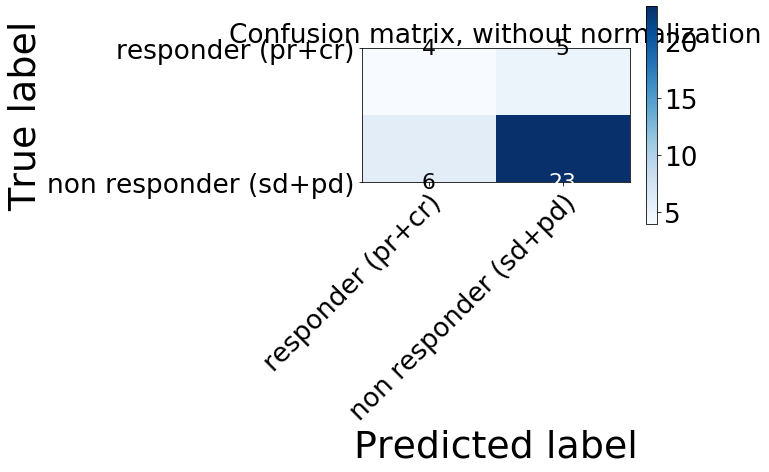

In [22]:
from views import plot_confusion_matrix
plot_confusion_matrix(y_test_resp, ps_class['LogisticRegression']['Lev'].predict(X_test), classes=y_test_resp.unique())

## Dimensional representation

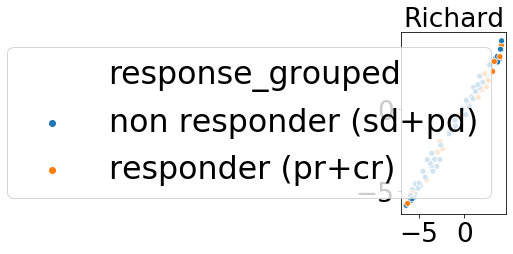

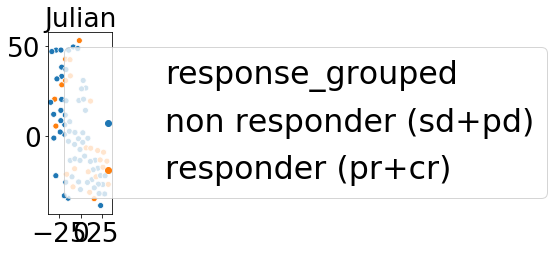

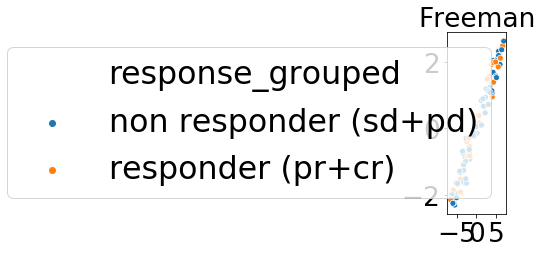

In [23]:
from views import view_pipelines

view_pipelines(ps_class['LogisticRegression'], X_train, y_train_resp, random_state=RANDOM_STATE)

## Regression

In [24]:
y_train_os = y_train['OS_days']
y_test_os = y_test['OS_days']
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']

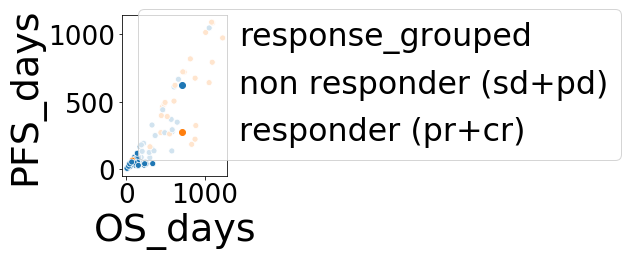

In [25]:
sns.scatterplot(x=y_train_os, y=y_train_pfs, hue=y_train_resp)

### Overall survival (OS)

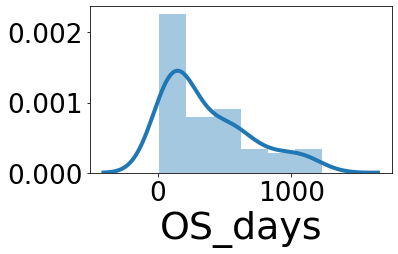

In [26]:
sns.distplot(y_train_os, norm_hist=False)

In [27]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_os, X_test, y_test_os, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [28]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    297.625073
Julian_test     273.258122
Freeman_test    638.191486
Lev_test        275.592300
dtype: float64
--------------------
DecisionTreeRegressor        292.752613
RandomForestRegressor        296.135597
GradientBoostingRegressor    283.486406
KNeighborsRegressor          332.427381
ElasticNet                   266.602818
LinearRegression             944.164203
SVR                          276.692136
DummyRegressor               277.072810
dtype: float64


In [29]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,325.220361,255.227153,325.070220,265.492716
RandomForestRegressor,319.476420,289.205408,285.673707,290.186853
GradientBoostingRegressor,291.651639,266.030076,306.855242,269.408665
KNeighborsRegressor,367.555823,289.899266,361.913946,310.340488
ElasticNet,259.651597,271.744500,271.537322,263.477855
LinearRegression,263.326068,260.780187,3000.364169,252.186388
SVR,277.045868,276.105578,277.044472,276.572626
DummyRegressor,277.072810,277.072810,277.072810,277.072810


## Progression Free Survival (PFS)

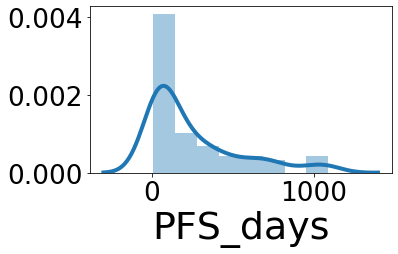

In [30]:
y_train_pfs = y_train['PFS_days']
y_test_pfs = y_test['PFS_days']
sns.distplot(y_train_pfs)

In [31]:
ps = build_regression_pipelines()
b = benchmark_pipelines(ps, X_train, y_train_pfs, X_test, y_test_pfs, metric=mean_squared_error)
# Root mean squared error.
b = b**0.5

In [32]:
print(b.mean(axis=0))
print('--'*10)
print(b.mean(axis=1))

Richard_test    304.173652
Julian_test     293.137569
Freeman_test    384.899778
Lev_test        291.883665
dtype: float64
--------------------
DecisionTreeRegressor        317.983523
RandomForestRegressor        296.599150
GradientBoostingRegressor    284.615919
KNeighborsRegressor          326.692031
ElasticNet                   279.248027
LinearRegression             445.714660
SVR                          298.613477
DummyRegressor               298.722543
dtype: float64


In [33]:
b

,Richard_test,Julian_test,Freeman_test,Lev_test
DecisionTreeRegressor,350.483267,272.840127,350.335608,298.275091
RandomForestRegressor,306.856493,293.009093,296.130773,290.400242
GradientBoostingRegressor,287.658628,283.096726,285.597283,282.111037
KNeighborsRegressor,338.227426,320.053519,336.586037,311.901144
ElasticNet,274.556071,288.689546,273.805864,279.940624
LinearRegression,278.169817,290.240609,939.309743,275.138470
SVR,298.714970,298.448391,298.710375,298.580171
DummyRegressor,298.722543,298.722543,298.722543,298.722543


## Multitask model


In [34]:
from sklearn.linear_model import MultiTaskElasticNet
from pipelines import pipelines
ps = pipelines(MultiTaskElasticNet, VotingEstimator=None)

In [35]:
Y_train = y_train[['OS_days', 'PFS_days']]
Y_test = y_test[['OS_days', 'PFS_days']]
rmse = lambda a, b: mean_squared_error(a, b, multioutput='raw_values')**0.5
benchmark_pipelines({'bla': ps}, X_train, Y_train, X_test, Y_test, metric=rmse)
# p = ps['Richard']
# p.fit(X_train, Y_train)

,Freeman_test,Julian_test,Richard_test
bla,"[268.42224374066984, 273.7039715426234]","[271.7399772705852, 288.69028307704565]","[260.2793678213237, 274.72849433265577]"
